# Projeto 5

## Bibliotecas e funções base

In [1]:
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math

In [2]:
def imagem_plot(img):
    fig, axes = plt.subplots(1, 1, figsize=(12, 6), sharex=True, sharey=True)
    axes.imshow(img)
    plt.xticks([]), plt.yticks([])
    plt.show()

In [3]:
def calculateOtsuVariables(hist_norm, xmin=0, size=256):
    Q = hist_norm.cumsum()
    bins = np.arange(size)
    fn_min = np.inf
    thresh = -1
    otsuMedian = [-1, -1]
    otsuDev = [-1, -1]
    for i in range(xmin + 1, xmin + size):
        p1, p2 = np.hsplit(hist_norm, [i])  # probabilities
        q1, q2 = Q[i], Q[xmin + size - 1] - Q[i]  # cum sum of classes
        if q1 == 0:
            q1 = 0.00000001
        if q2 == 0:
            q2 = 0.00000001
        b1, b2 = np.hsplit(bins, [i])  # weights
        # finding means and variances
        m1, m2 = np.sum(p1 * b1) / q1, np.sum(p2 * b2) / q2
        v1, v2 = np.sum(((b1 - m1) ** 2) * p1) / q1, np.sum(((b2 - m2) ** 2) * p2) / q2
        # calculates the minimization function
        fn = v1 * q1 + v2 * q2
        if fn < fn_min:
            fn_min = fn
            thresh = i
            otsuMedian[0] = m1
            otsuMedian[1] = m2
            otsuDev[0] = np.sqrt(v1)
            otsuDev[1] = np.sqrt(v2)
    return(otsuMedian, otsuDev, thresh)

## Abrir a imagem

Todas imagens serão abertas no padrão BGR pelo OpenCV, sendo assim podemos alterar esse formato para facilitar nosso trabalho.

Primeiro, vamos conveter todas imagens para o padrão RGB para funcionar com o _matplotlib.pyplot_.

Outros formatos que vamos adotar são os HLS e HSV para facilitar em algumas operações.

In [4]:
# Nome da imagem
IMGS = ["input/{0}.bmp".format(i) for i in range(0, 10)]

# Abrindo a imagem
imgs = [cv2.imread(name) for name in IMGS]

background = cv2.cvtColor(cv2.imread("input/background1.bmp"), cv2.COLOR_BGR2RGB)

# Converter para RGB
RGB_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in imgs]
HLS_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2HLS) for img in imgs]
HSV_imgs = [cv2.cvtColor(img, cv2.COLOR_BGR2HSV) for img in imgs]
MASK_imgs = [np.zeros(img.shape).astype(float) for img in RGB_imgs]

## Tratar imagem

### Histogramas

Vamos visualizar os histogramas da imagem quando utilizada nos formatos RGB, HLS e HSV.

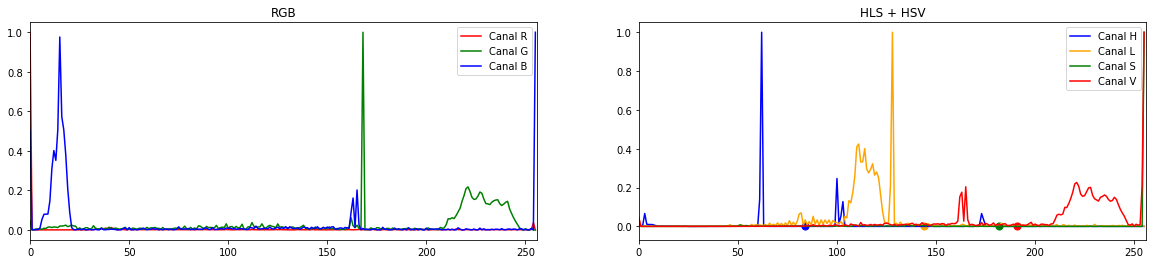

62


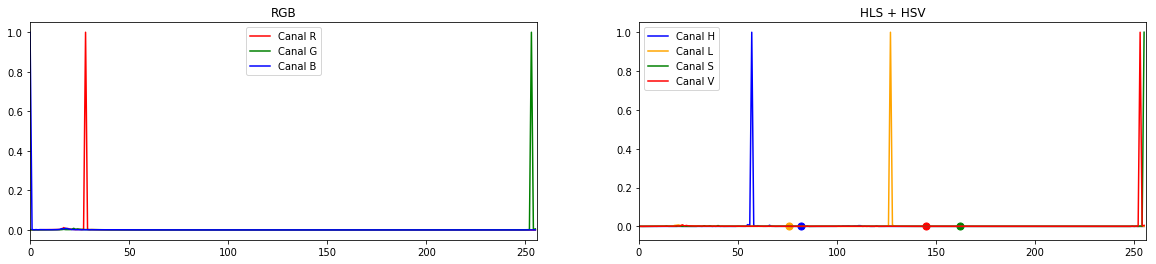

57


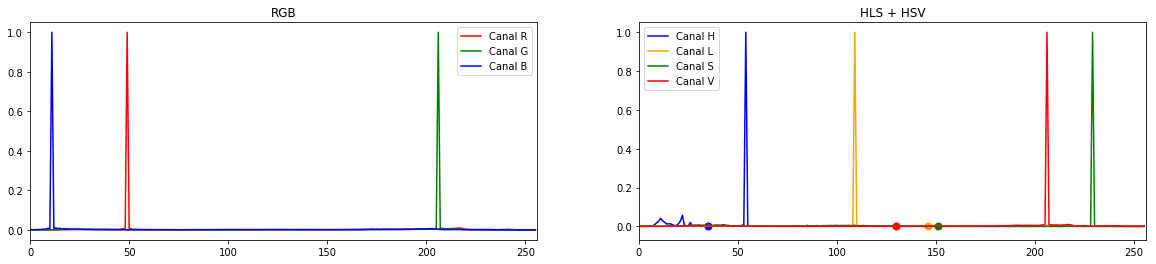

54


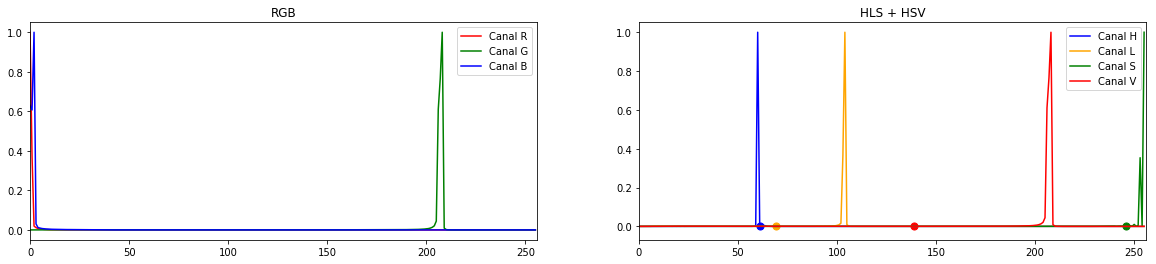

60


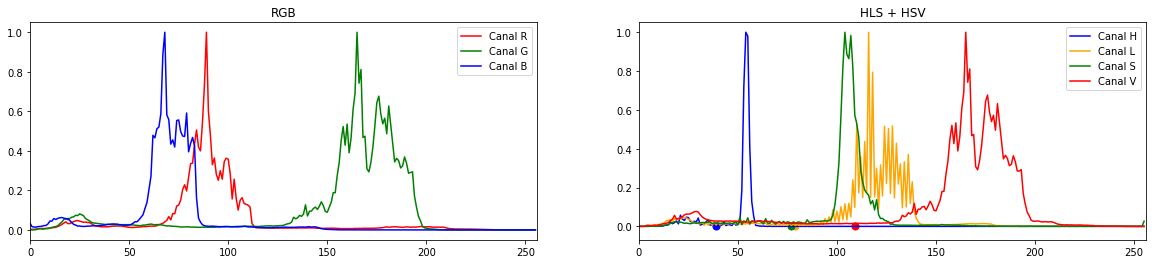

54


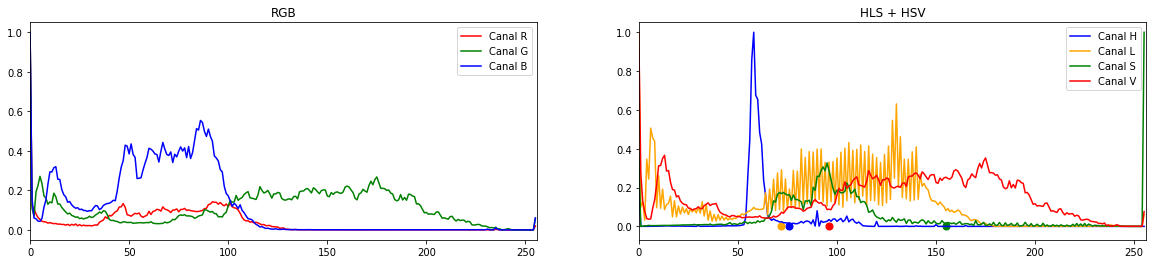

58


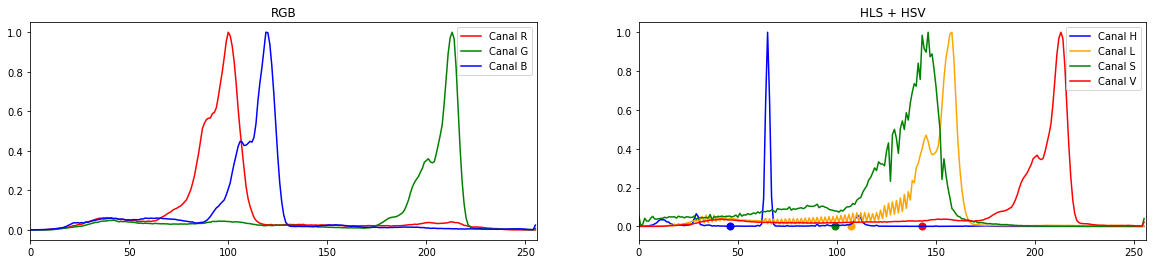

65


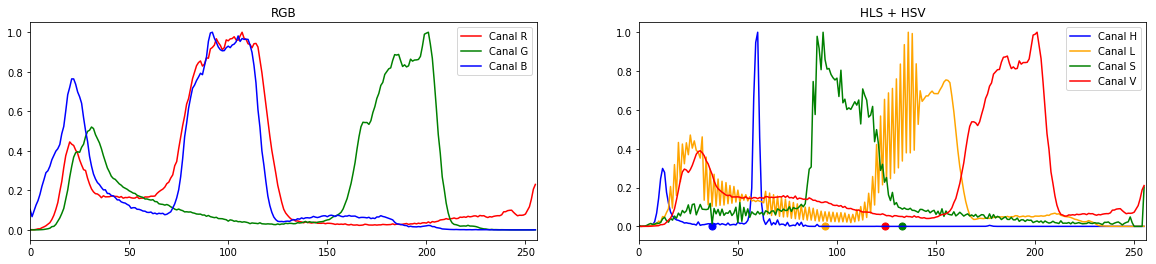

60


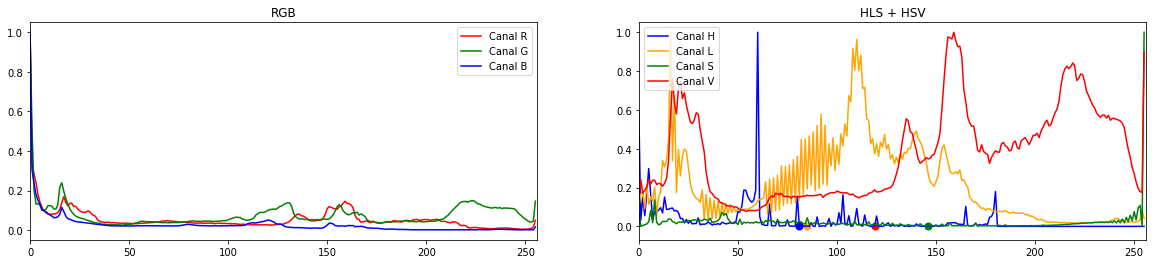

60


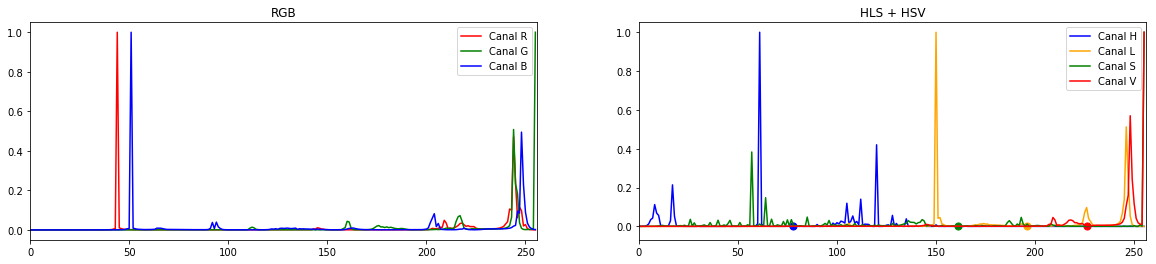

61


In [5]:
for rgb_img, hls_img, hsv_img, mask in zip(RGB_imgs, HLS_imgs, HSV_imgs, MASK_imgs):
    # Para cada imagem ...
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,4), sharex=True)

    # Imagem formato RGB
    #    Canal R
    hist11 = cv2.calcHist([rgb_img], [0], None, [256], [0, 256])
    ax1.plot(hist11.ravel().astype(float) / hist11.max(), color="red", label="Canal R")
    #    Canal G
    hist12 = cv2.calcHist([rgb_img], [1], None, [256], [0, 256])
    ax1.plot(hist12.ravel().astype(float) / hist12.max(), color="green", label="Canal G")
    #    Canal B
    hist13 = cv2.calcHist([rgb_img], [2], None, [256], [0, 256])
    ax1.plot(hist13.ravel().astype(float) / hist13.max(), color="blue", label="Canal B")
    # Plotar
    ax1.set_title("RGB")
    ax1.legend()
    
    # Imagem formato HLS
    hls_blur = cv2.GaussianBlur(hls_img,(5,5),0)
    hsv_blur = cv2.GaussianBlur(hsv_img,(5,5),0)
    h_ret, h_th = cv2.threshold(hls_blur[:,:,0], 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    l_ret, l_th = cv2.threshold(hls_blur[:,:,1], 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    s_ret, s_th = cv2.threshold(hls_blur[:,:,2], 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    v_ret, v_th = cv2.threshold(hsv_blur[:,:,2], 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #    Canal H
    hist21 = cv2.calcHist([hls_img], [0], None, [256], [0, 256])
    ax2.plot(hist21.ravel().astype(float) / hist21.max(), label="Canal H", color="blue")
    #    Canal L
    hist22 = cv2.calcHist([hls_img], [1], None, [256], [0, 256])
    ax2.plot(hist22.ravel().astype(float) / hist22.max(), label="Canal L", color="orange")
    #    Canal S
    hist23 = cv2.calcHist([hls_img], [2], None, [256], [0, 256])
    ax2.plot(hist23.ravel().astype(float) / hist23.max(), label="Canal S", color="green")
    #    Canal V
    hist33 = cv2.calcHist([hsv_img], [2], None, [256], [0, 256])
    ax2.plot(hist33.ravel().astype(float) / hist33.max(), label="Canal V", color="red")
    # Plotar
    ax2.set_title("HLS + HSV")
    ax2.legend()
    
    ax2.scatter(h_ret, 0, s=50, color="blue")
    ax2.scatter(l_ret, 0, s=50, color="orange")
    ax2.scatter(s_ret, 0, s=50, color="green")
    ax2.scatter(v_ret, 0, s=50, color="red")

    ax1.set_xlim([0,256])
    ax2.set_xlim([0,256])
    plt.show()
    
    print(hist21.argmax())

### Encontrar o "verde" da imagem

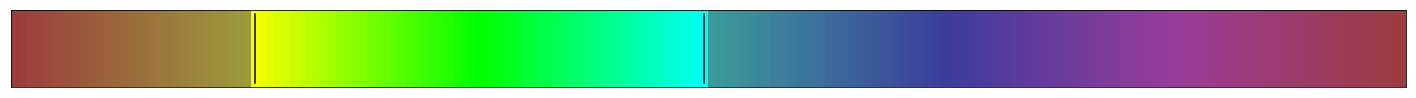

In [6]:
hue_hsv = np.uint8([[(hue, 255, 255) for hue in range(0,180)] for dummy in range(0,10)])
hue_rgb = cv2.cvtColor(cv2.cvtColor(hue_hsv, cv2.COLOR_HSV2BGR), cv2.COLOR_BGR2RGB)

hue_cond = np.all([(hue_rgb[:,:,2] < hue_rgb[:,:,1]).ravel(), 
                   (hue_rgb[:,:,0] < hue_rgb[:,:,1]).ravel()], 
                  axis=0).reshape((hue_hsv.shape[0], hue_hsv.shape[1]))

hue_hsv[hue_cond == False] = hue_hsv[hue_cond == False] * (1, 0, 0) + (0, 155, 155)
hue_rgb = cv2.cvtColor(cv2.cvtColor(hue_hsv, cv2.COLOR_HSV2BGR), cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 1, figsize=(25, 15), sharex=True, sharey=True)
axes.imshow(hue_rgb)
axes.plot([31, 31], [0, 9], color="black")
axes.plot([89, 89], [0, 9], color="black")
plt.xticks([]), plt.yticks([])
plt.show()

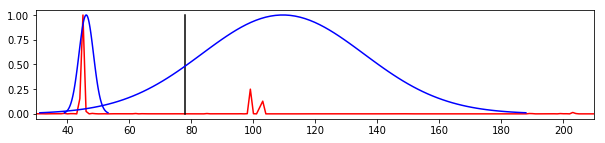

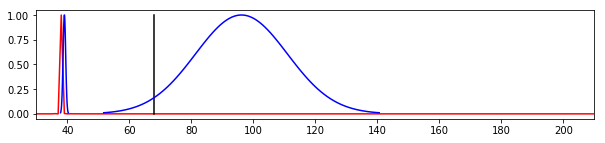

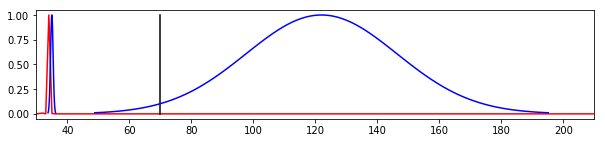

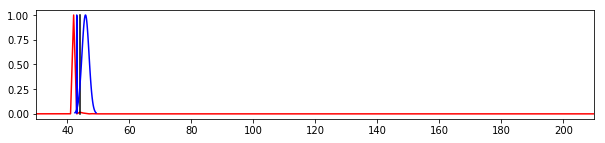

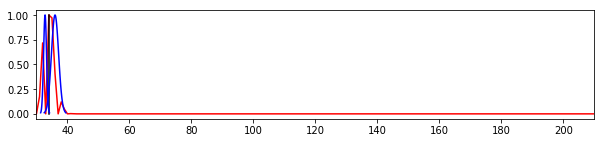

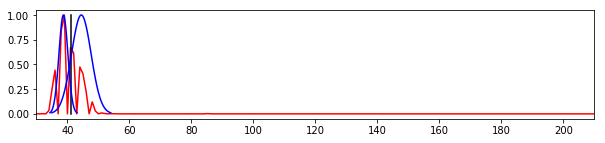

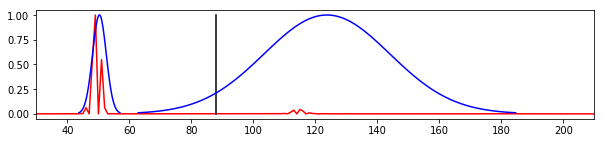

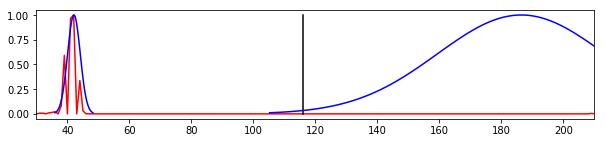

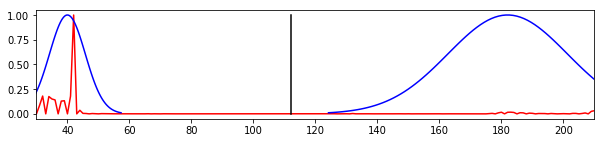

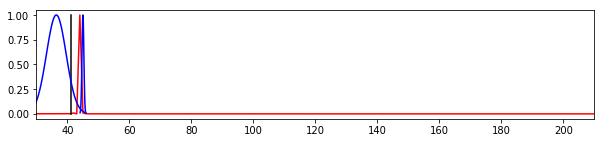

In [7]:
for rgb_img, hls_img, hsv_img, mask in zip(RGB_imgs, HLS_imgs, HSV_imgs, MASK_imgs):

    blur = cv2.GaussianBlur(hsv_img,(5,5),0).astype(float)
    blur[blur[:,:,0] < 30, 0] += 180
    blur = blur[np.all([(blur[:,:,1] > (255.0 * 0.4)).ravel(), 
                        (blur[:,:,2] > (255.0 * 0.3)).ravel()], 
                       axis=0).reshape(blur[:,:,0].shape), 0]

    # Histograma do Hue
    hist = cv2.calcHist([np.uint8(blur)], [0], None, [256], [30, 210])
    hist_norm = hist.ravel().astype(float) / (hist.max() if hist.max() > 0 else 255)

    # Calcular Otsu
    [med1, med2], [sigma1, sigma2], th = calculateOtsuVariables(hist_norm[29:209], xmin=0, size=180)
    med1 += 30
    med2 += 30
    th += 30

    # Plotar
    fig, axes = plt.subplots(1, 1, figsize=(10, 2), sharex=True, sharey=True)
    #  Histograma Hue
    axes.plot(hist_norm, color="red", label="Matiz deslocado")
    axes.plot([th, th], [0, 1], color="black")
    #  Gaussiana 1
    x1 = np.linspace(med1 - 3 * sigma1, med1 + 3 * sigma1, 100)
    y1 = stats.norm.pdf(x1, med1, sigma1)
    axes.plot(x1, y1 / y1.max(), color="blue")
    #  Gaussiana 2
    x2 = np.linspace(med2 - 3 * sigma2, med2 + 3 * sigma2, 100)
    y2 = stats.norm.pdf(x2, med2, sigma2)
    axes.plot(x2, y2 / y2.max(), color="blue")

    axes.set_xlim([30, 210])
    #axes.set_xlim([0, 255])
    plt.show()

    # Ver binarizado
    #mask.fill(0.0)
    #mask[np.all([(hsv_img[:,:,0] >= 30).ravel(), 
    #             (hsv_img[:,:,0] < th).ravel()], 
    #            axis=0).reshape(hsv_img[:,:,0].shape)] = (1.0, 1.0, 1.0)

    # imagem_plot((rgb_img * mask).astype(np.uint8))

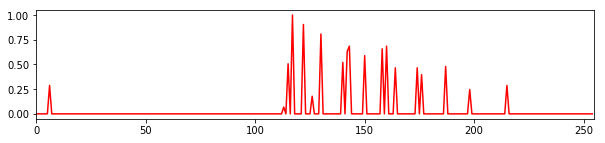

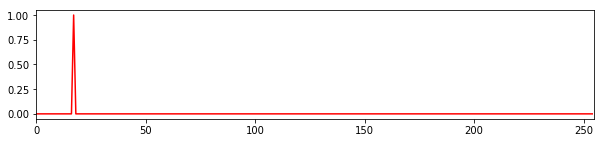

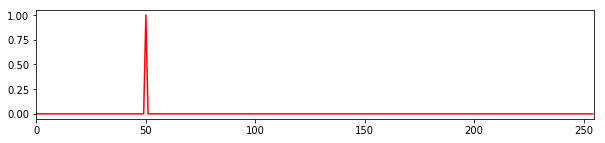

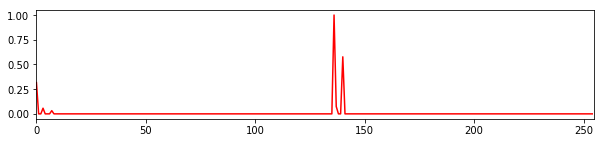

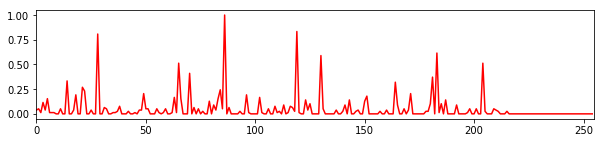

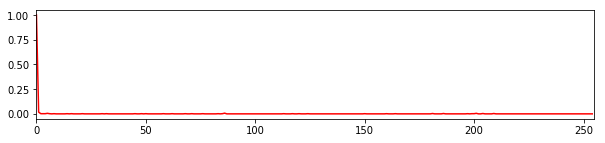

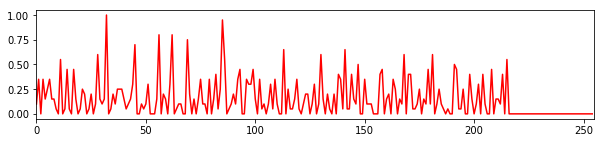

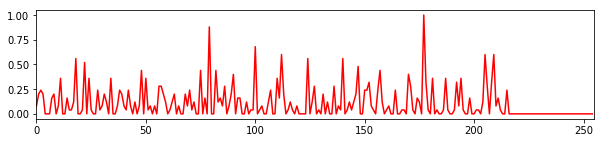

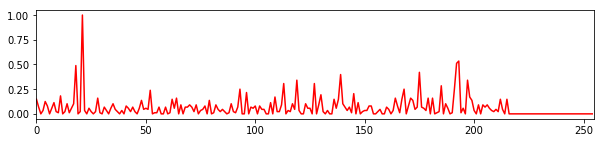

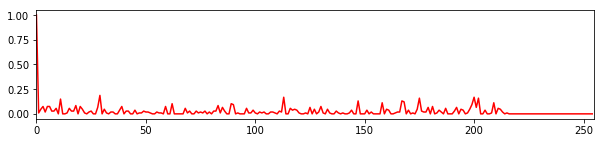

In [8]:
for rgb_img, hls_img, hsv_img, mask in zip(RGB_imgs, HLS_imgs, HSV_imgs, MASK_imgs):

    green_pixel = [0, 255, 0]

    blur = cv2.GaussianBlur(rgb_img, (5,5), 3)
    dist = blur[:,:,0]**2 + (1 - blur[:,:,1])**2 + blur[:,:,2]**2

    hist = cv2.calcHist([np.array([dist])], [0], None, [255], [0, 300])
    hist_norm = hist.ravel().astype(float) / hist.max()

    fig, axes = plt.subplots(1, 1, figsize=(10, 2), sharex=True, sharey=True)
    axes.plot(hist_norm, color="red", label="Distâncias")
    axes.set_xlim([0, 255])
    plt.show()

### Montar a máscara

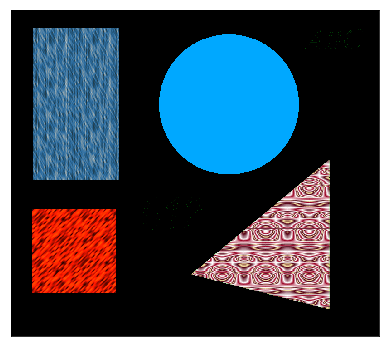

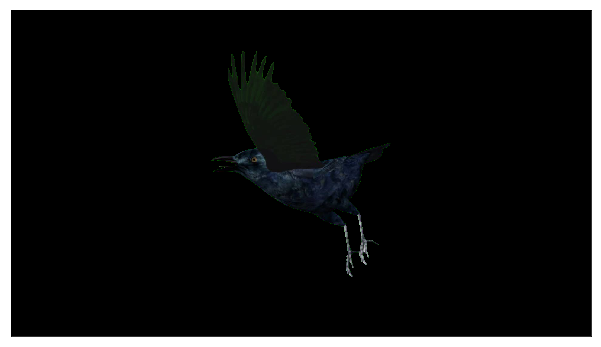

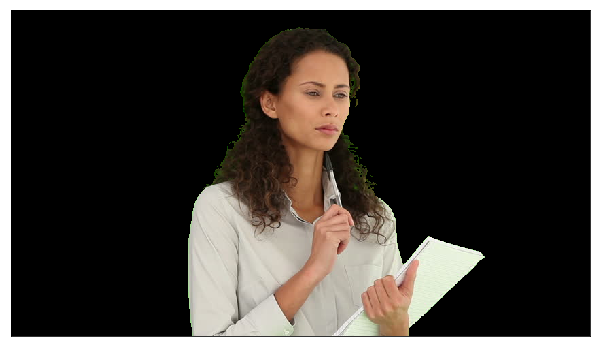

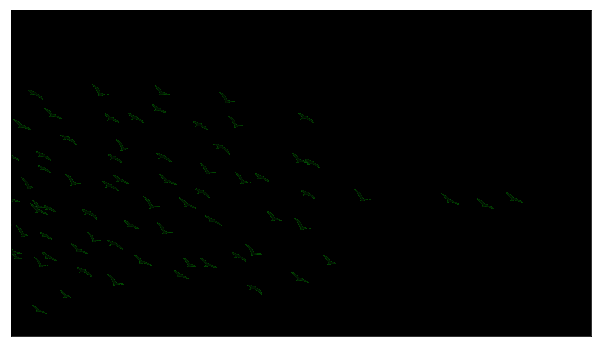

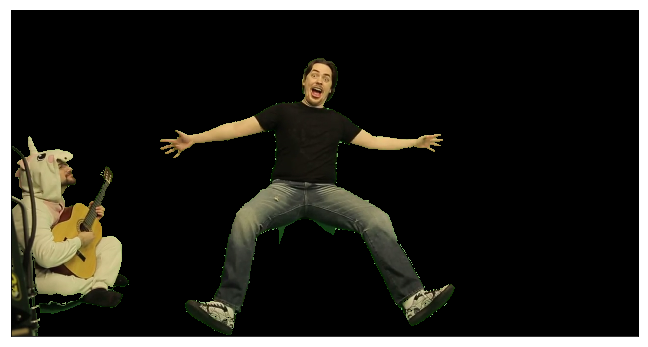

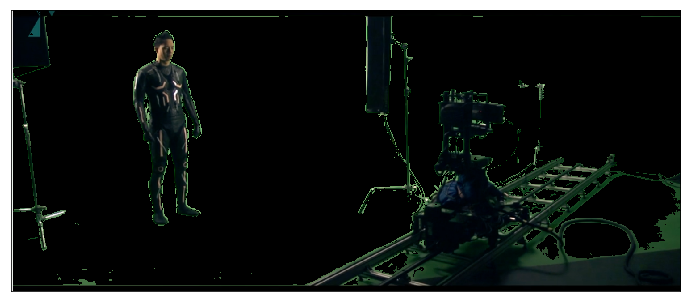

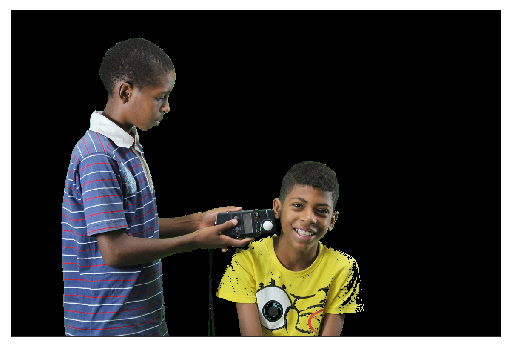

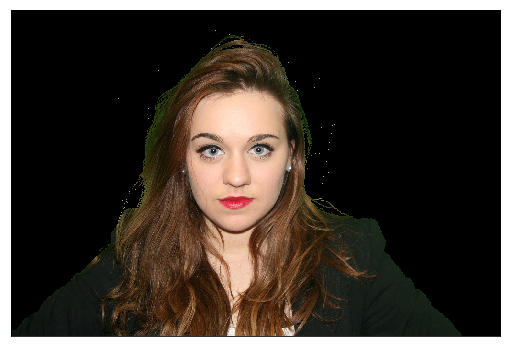

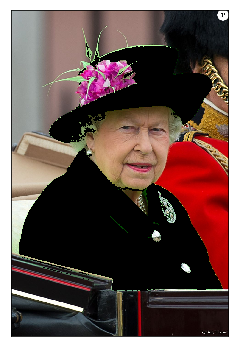

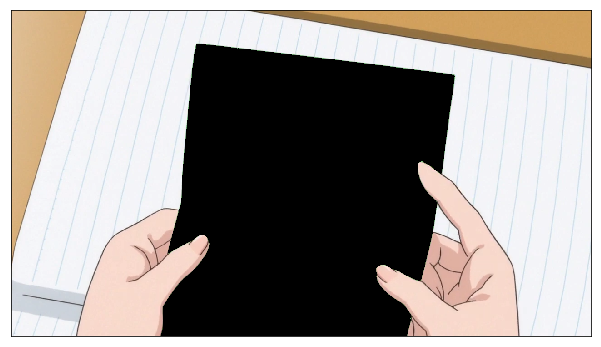

In [13]:
def mask001(rgb_img, hls_img, hsv_img, mask):
    mask.fill(0.0)
    cond = np.all([(hsv_img[:,:,0] > 30).ravel(),
                   (hsv_img[:,:,0] < 90).ravel(),
                   (hsv_img[:,:,1] > 0.4 * 255).ravel(),
                   (hsv_img[:,:,2] > 0.3 * 255).ravel()
                  ], axis=0).reshape(hsv_img[:,:,0].shape)
    mask[cond] = (1.0, 1.0, 1.0)
    mask.clip(min=0, max=1)
    return mask

def mask002(rgb_img, hls_img, hsv_img, mask):
    mask.fill(0.0)
    # Tirar verde
    cond1 = np.all([(hsv_img[:,:,0] > 30).ravel(), 
                    (hsv_img[:,:,0] < 90).ravel(),
                    (hsv_img[:,:,1] > 0.4 * 255).ravel(),
                    (hsv_img[:,:,2] > 0.3 * 255).ravel()
                   ], axis=0).reshape(hsv_img[:,:,0].shape)
    # Tirar quase verde
    cond2 = np.all([(hsv_img[:,:,0] > 40).ravel(), 
                    (hsv_img[:,:,0] < 70).ravel(),
                    (hsv_img[:,:,1] > 0.15 * 255).ravel(),
                    (hsv_img[:,:,2] > 0.15 * 255).ravel()
                   ], axis=0).reshape(hsv_img[:,:,0].shape)
    mask[cond2,0] = hsv_img[cond2,2] / 255.0 * (1/0.3)
    mask[cond2,1] = hsv_img[cond2,2] / 255.0 * (1/0.3)
    mask[cond2,2] = hsv_img[cond2,2] / 255.0 * (1/0.3)
    mask[cond1] = (1.0, 1.0, 1.0)
    mask.clip(min=0, max=1)
    return mask

def mask003(rgb_img, hls_img, hsv_img, mask):
    mask.fill(0.0)
    # Tirar verde
    cond = np.all([(rgb_img[:,:,0] < rgb_img[:,:,1]).ravel(),
                   (rgb_img[:,:,2] < rgb_img[:,:,1]).ravel()
                  ], axis=0).reshape(rgb_img[:,:,0].shape)
    mask[cond] = (1.0, 1.0, 1.0)
    mask.clip(min=0, max=1)
    return mask

for rgb_img, hls_img, hsv_img, mask in zip(RGB_imgs, HLS_imgs, HSV_imgs, MASK_imgs):
    mask = mask001(rgb_img, hls_img, hsv_img, mask)
    imagem_plot((rgb_img * (1.0 - mask)).astype(np.uint8))


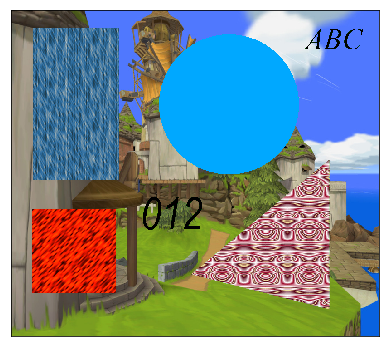

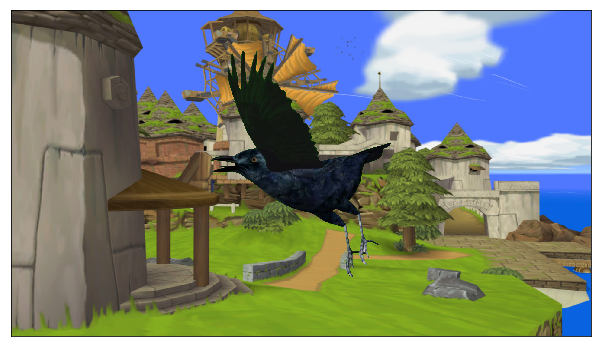

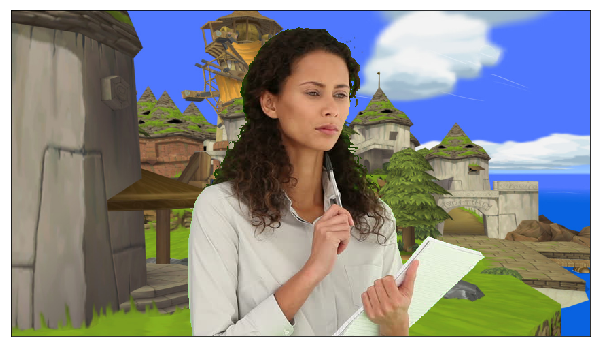

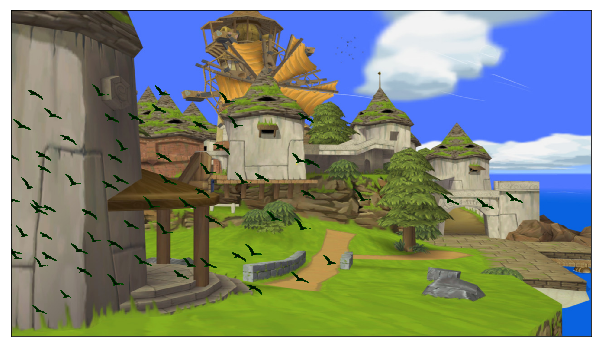

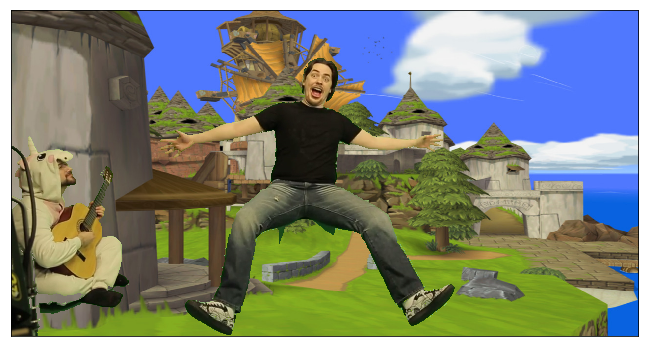

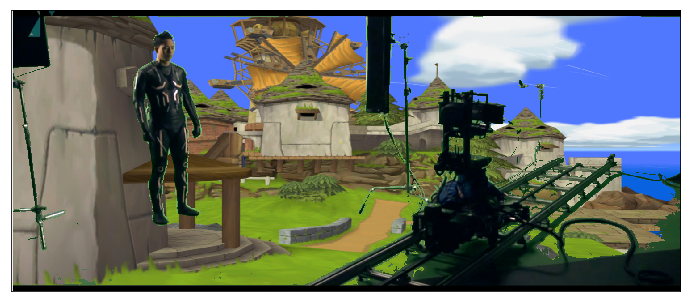

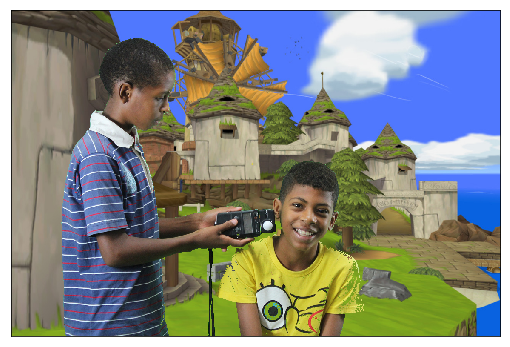

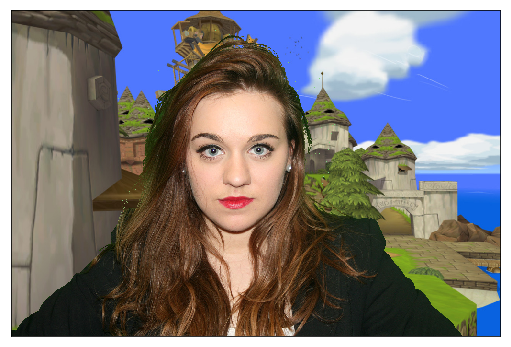

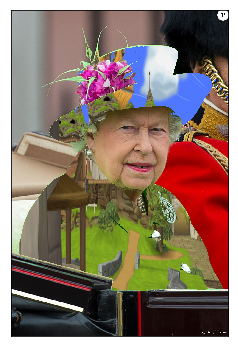

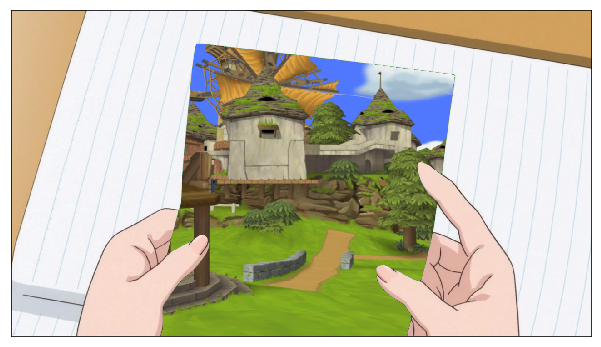

In [10]:
for rgb_img, hls_img, hsv_img, mask in zip(RGB_imgs, HLS_imgs, HSV_imgs, MASK_imgs):
    fg = rgb_img.copy().astype(float)
    bg = background.copy().astype(float)
    bg = cv2.resize(bg, (fg.shape[1], fg.shape[0]))
    
    # Multiply the foreground with the alpha matte
    fg = cv2.multiply(1.0 - mask, fg)

    # Multiply the background with ( 1 - alpha )
    bg = cv2.multiply(mask, bg)

    # Add the masked foreground and background.
    outImage = cv2.add(fg, bg)

    imagem_plot(outImage.astype(int))